# Kalshi

In [134]:
from src.client import KalshiClient, ExchangeClient
from datetime import datetime

import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
host = 'https://trading-api.kalshi.com/trade-api/v2'
client = ExchangeClient(host, 'EMAIL', 'PASSWORD')
client.get_exchange_status()

{'exchange_active': True, 'trading_active': True}

Test that we are authenticated:

This gave me issues for a few days, some things to note: 

- The python wrapper api is a complete bait, they basically auto generated with swagger. Still has a deprecated get_market_history function, instead of the get_market_candlesticks that is used below. Also hasn't been updated in a year! 
- The API keys were not working for me. Not really sure what it's supposed to be used for, the only thing that worked was using the email/password authentication with tokens. 

In [ ]:
ticker = 'HIGHCHI-24SEP22-T76'
series_ticker = 'HIGHCHI'
start = int(datetime(2024, 9, 21).timestamp())
end = int(datetime(2024, 9, 22).timestamp())
client.get_market_candlesticks(ticker, series_ticker, start, end, 60)

## Calibration test

For prediction markets, we can test "calibration" of the market by looking at how efficiently the market predicts resolution half way to expiry. 

I.e, if Kalshi is predicting yes at 10% odds for a subset of markets, then we should expect 10% of them to resolve to yes. We would expect a perfectly efficient market to have this property for any probability.

In [91]:
calibration = pd.DataFrame(columns=['market', 'prediction', 'resolution', 'open_dt', 'close_dt', 'prediction_dt'])

In [94]:
cursor = ''
while True:
    resp = client.get_markets(cursor=cursor, limit=1000, status='settled')
    cursor = resp['cursor']

    for market in resp['markets']: 
        result = market['result']
        ticker = market['ticker']
        series_ticker = market['event_ticker'].split('-')[0]
        open_dt = pd.to_datetime(market['open_time'])
        close_dt = pd.to_datetime(market['close_time'])
        dt_delta = (close_dt - open_dt)/2
        
        # halfway to expiry
        midpt_dt = (open_dt + dt_delta)
        end_dt = midpt_dt + pd.Timedelta(24, 'h')
        
        candle_resp = client.get_market_candlesticks(ticker, 
                                                    series_ticker, 
                                                    int(midpt_dt.to_pydatetime().timestamp()),
                                                    int(end_dt.to_pydatetime().timestamp()),
                                                    60)
        candlesticks = candle_resp['candlesticks']
        candle_df = pd.DataFrame([(candle['end_period_ts'], candle['price']['mean']) for candle in candlesticks],
                                columns=['end_dt', 'midpt_price'])
        candle_df['end_dt'] = candle_df['end_dt'].apply(lambda ts : datetime.fromtimestamp(ts))
        candle_df = candle_df.set_index('end_dt')

        # get what datetime we are taking the price of
        # and append to the dataframe
        pred_dt = candle_df.first_valid_index()

        if pred_dt is not None:
            price = candle_df.loc[pred_dt].values[0]

            row = pd.DataFrame({
                'market' : ticker, 
                'prediction' : price, 
                'resolution' : result, 
                'open_dt' : open_dt, 
                'close_dt' : close_dt,
                'prediction_dt' : pred_dt
            }, index=[0])

            print(row)
            calibration = pd.concat([calibration, row], axis=0)

        time.sleep(1)

    if cursor == '':
        break

calibration.to_csv('calibration.csv')

                market  prediction resolution                   open_dt  \
0  HIGHMIA-24SEP21-T92        23.0         no 2024-09-20 14:00:00+00:00   

                   close_dt       prediction_dt  
0 2024-09-22 03:59:00+00:00 2024-09-21 09:00:00  
                  market  prediction resolution                   open_dt  \
0  HIGHMIA-24SEP21-B91.5        45.0        yes 2024-09-20 14:00:00+00:00   

                   close_dt       prediction_dt  
0 2024-09-22 03:59:00+00:00 2024-09-21 09:00:00  
                  market  prediction resolution                   open_dt  \
0  HIGHMIA-24SEP21-B89.5        31.0         no 2024-09-20 14:00:00+00:00   

                   close_dt       prediction_dt  
0 2024-09-22 03:59:00+00:00 2024-09-21 09:00:00  
                  market  prediction resolution                   open_dt  \
0  HIGHMIA-24SEP21-B87.5        45.0         no 2024-09-20 14:00:00+00:00   

                   close_dt       prediction_dt  
0 2024-09-22 03:59:00+00:00 2024-0

KeyboardInterrupt: 

In [95]:
calibration.to_csv('calibration.csv')
calibration = calibration.set_index('market')

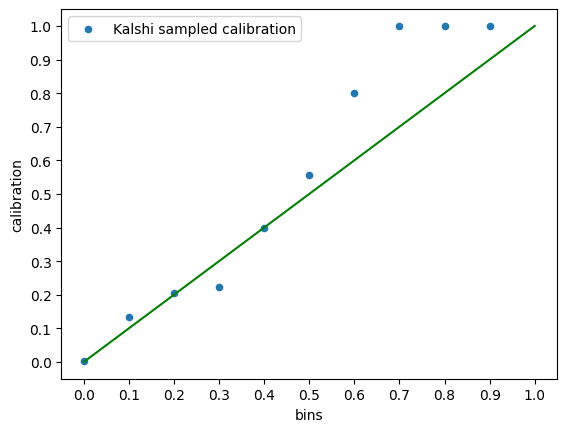

In [160]:
# (bin start, label) pairs
labels = list(zip([x/10 for x in range(0,11)], [x for x in range(0,11)]))
bins = pd.cut(calibration['prediction'], [x/10 for x in range(0,11)], [x for x in range(0,11)], labels=False)
calibration['bins'] = bins
calibration_bins = calibration[['bins', 'resolution']].groupby('bins').apply(lambda grpby : len(grpby[grpby['resolution'] == 'yes']) / len(grpby), include_groups=False)
calibration_bins = calibration_bins.reset_index().rename({0 : 'calibration'}, axis=1)
calibration_bins['bins'] = calibration_bins['bins']/10
calibration_bins.plot.scatter(x='bins', y='calibration', xticks=[x/10 for x in range(11)], yticks=[x/10 for x in range(11)], label='Kalshi sampled calibration')
plt.plot([x/10 for x in range(11)], [x/10 for x in range(11)], label='perfect calibration', color='g')